<a href="https://colab.research.google.com/github/juandahur/IA_UdeA/blob/main/ProyectoGrado.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#PHM North America 2024 Conference Data Challenge

##Objective

This year’s data challenge is on estimating the health of helicopter turbine engines. It is both a regression and classification problem. We also want to know how trustworthy the algorithm(s) are, so a measure of confidence will be reported for each of your predictions. Our intent is that the design of this confidence metric is as important as the prediction itself.

##Problem

This year’s problem is to assess the health of helicopter turbine engines. The combined datasets has seven engines (assets) all of the same make and model. You will be given all of the measured data for four of the assets in the training dataset, but the observations have been shuffled and asset ids have been removed. The remaining three assets are used to form the test and validation datasets.
Note that your algorithms will have to generalize on assets on which they were not trained.

Each engine is instrumented to capture the outside air temperature, mean gas temperature, power available, indicated airspeed, net power, and compressor speed. For these operational conditions, there is a design (target) torque. The real output torque is also measured. Engine health is assessed by comparing the output torque to the design torque. More specifically, we look at the torque margin as an indicator of engine health:

* torque margin (%) = 100 * (torque measured – torque target) / torque target

Thus it can be observed if an engine underperforming.

For each observation in the test and validation datasets, competing teams will predict the asset’s health by

* Estimating the binary classification of the health state (0 = nominal, 1 = faulty), and confidence metric (continuous variable 0 to 1).
* Estimating the torque margin expressed at a probability distribution function (PDF). Teams can select from a list of PDFs. This is probabilistic regression.

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib as mpl

import warnings

#plt.rcParams['figure.figsize'] = [8,5]
sns.set_style('white')
mpl.style.use('ggplot')


plt.rcParams['font.size'] =14
plt.rcParams['font.weight']= 'bold'
plt.style.use('seaborn-whitegrid')

<ipython-input-3-3d01cc25ead7>:17: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


In [4]:
X_train = pd.read_csv('/content/drive/MyDrive/BD & BI - EIA/ProyectoGrado/Datasets/X_train.csv')

In [5]:
X_train.head(5)

,id,trq_measured,oat,mgt,pa,ias,np,ng
0,0,54.100,2.00000,544.5000,212.1408,74.56250,89.18000,99.6400
1,1,49.625,24.22231,578.4844,1625.6400,30.35596,99.55273,91.3866
2,2,52.000,7.00000,566.1000,1912.9250,65.62500,100.14000,90.9600
3,3,62.400,7.25000,560.1000,277.0632,54.81250,90.64000,100.2800
4,4,62.900,23.25000,593.7000,53.6448,73.43750,99.91000,92.1700


In [6]:
y_train = pd.read_csv('/content/drive/MyDrive/BD & BI - EIA/ProyectoGrado/Datasets/y_train.csv')

In [7]:
y_train

,id,faulty,trq_margin
0,0,1,-13.717745
1,1,0,1.791863
2,2,1,-13.944871
3,3,0,-0.017281
4,4,0,7.322404
...,...,...,...
742620,742620,0,5.046813
742621,742621,0,14.997595
742622,742622,0,-7.298636
742623,742623,0,6.781313


In [8]:
data = pd.merge(X_train, y_train, on='id', how='inner')

In [9]:
data.head(5)

,id,trq_measured,oat,mgt,pa,ias,np,ng,faulty,trq_margin
0,0,54.100,2.00000,544.5000,212.1408,74.56250,89.18000,99.6400,1,-13.717745
1,1,49.625,24.22231,578.4844,1625.6400,30.35596,99.55273,91.3866,0,1.791863
2,2,52.000,7.00000,566.1000,1912.9250,65.62500,100.14000,90.9600,1,-13.944871
3,3,62.400,7.25000,560.1000,277.0632,54.81250,90.64000,100.2800,0,-0.017281
4,4,62.900,23.25000,593.7000,53.6448,73.43750,99.91000,92.1700,0,7.322404


In [10]:
data = data.drop('id', axis=1)

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 742625 entries, 0 to 742624
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   trq_measured  742625 non-null  float64
 1   oat           742625 non-null  float64
 2   mgt           742625 non-null  float64
 3   pa            742625 non-null  float64
 4   ias           742625 non-null  float64
 5   np            742625 non-null  float64
 6   ng            742625 non-null  float64
 7   faulty        742625 non-null  int64  
 8   trq_margin    742625 non-null  float64
dtypes: float64(8), int64(1)
memory usage: 51.0 MB


In [12]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
trq_measured,742625.0,65.097549,13.253672,14.673340,56.100000,65.700000,75.500000,104.730500
oat,742625.0,12.675167,8.066084,-19.250000,7.500000,13.703440,18.500000,36.799130
mgt,742625.0,592.246116,39.654582,467.300000,562.400000,589.400000,622.300000,723.400000
pa,742625.0,511.776065,563.190555,-208.389200,135.331200,340.461600,588.264000,3097.510000
ias,742625.0,79.324591,35.395075,0.000000,51.125000,88.375000,110.562500,137.562500
np,742625.0,97.377919,3.996721,85.010000,95.330000,99.759770,100.020000,101.560000
ng,742625.0,95.517281,3.635084,90.001830,92.226440,94.810000,99.900000,101.220000
faulty,742625.0,0.403189,0.490538,0.000000,0.000000,0.000000,1.000000,1.000000
trq_margin,742625.0,-1.157346,14.068843,-74.747111,-6.604321,1.693847,7.785348,34.148857


In [13]:
#data['faulty'] = data['faulty'].astype(object)

In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 742625 entries, 0 to 742624
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   trq_measured  742625 non-null  float64
 1   oat           742625 non-null  float64
 2   mgt           742625 non-null  float64
 3   pa            742625 non-null  float64
 4   ias           742625 non-null  float64
 5   np            742625 non-null  float64
 6   ng            742625 non-null  float64
 7   faulty        742625 non-null  int64  
 8   trq_margin    742625 non-null  float64
dtypes: float64(8), int64(1)
memory usage: 51.0 MB


### Separete 2 Datasets

In [15]:
data_hs = data.drop('trq_margin', axis=1)
data_hs

,trq_measured,oat,mgt,pa,ias,np,ng,faulty
0,54.100,2.00000,544.5000,212.1408,74.56250,89.18000,99.6400,1
1,49.625,24.22231,578.4844,1625.6400,30.35596,99.55273,91.3866,0
2,52.000,7.00000,566.1000,1912.9250,65.62500,100.14000,90.9600,1
3,62.400,7.25000,560.1000,277.0632,54.81250,90.64000,100.2800,0
4,62.900,23.25000,593.7000,53.6448,73.43750,99.91000,92.1700,0
...,...,...,...,...,...,...,...,...
742620,79.600,10.50000,613.9000,475.7928,83.31250,94.93000,99.8400,0
742621,63.100,24.00000,586.2000,288.0360,94.81250,93.14000,100.3000,0
742622,82.400,10.50000,656.7000,441.0456,119.56250,97.08000,99.7600,0
742623,68.500,18.75000,598.1000,73.4568,110.06250,100.11000,93.0900,0


# Health State (Faulty)

##Univariate analysis

<Axes: xlabel='faulty'>

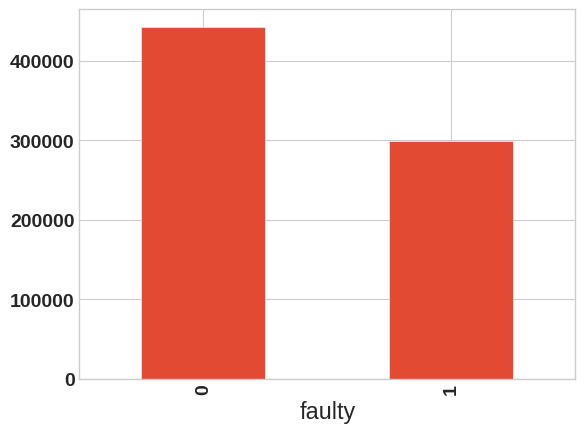

In [16]:
data_hs['faulty'].value_counts().plot(kind='bar')

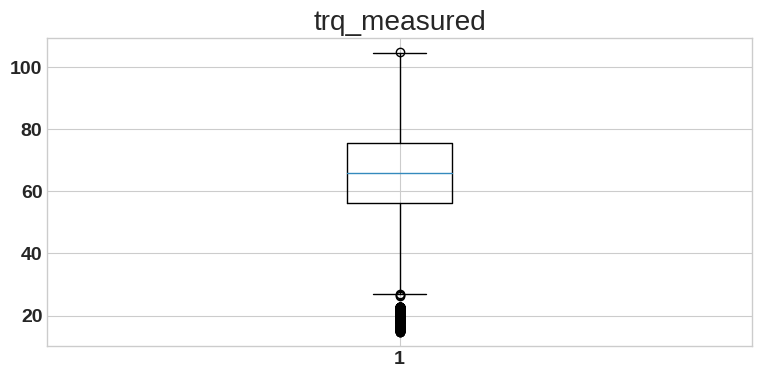

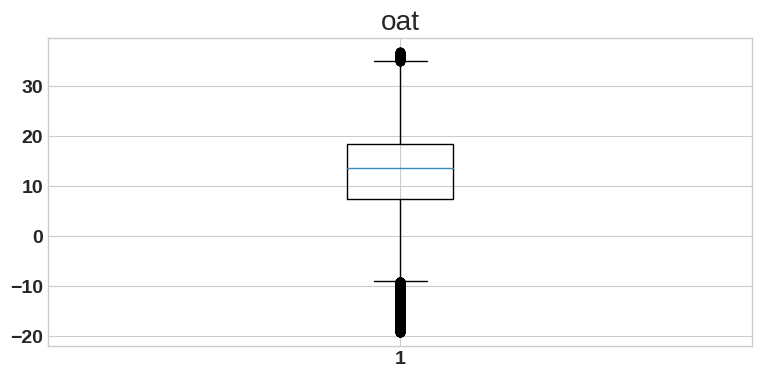

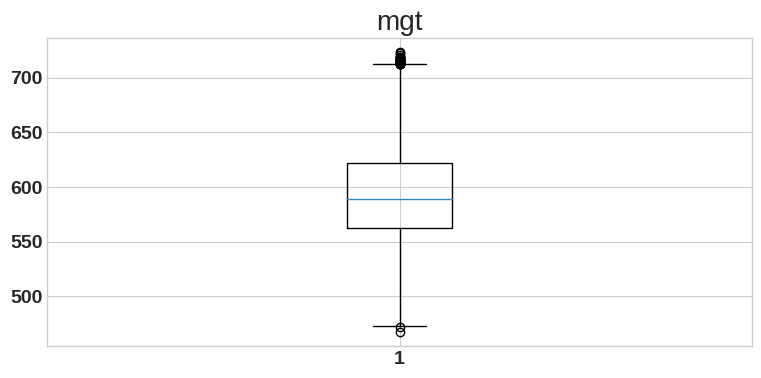

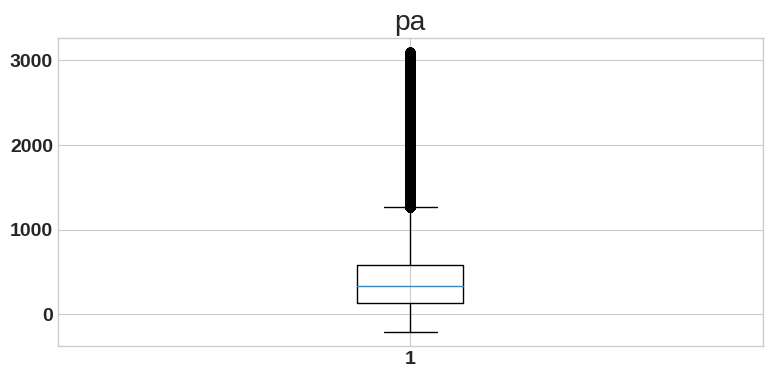

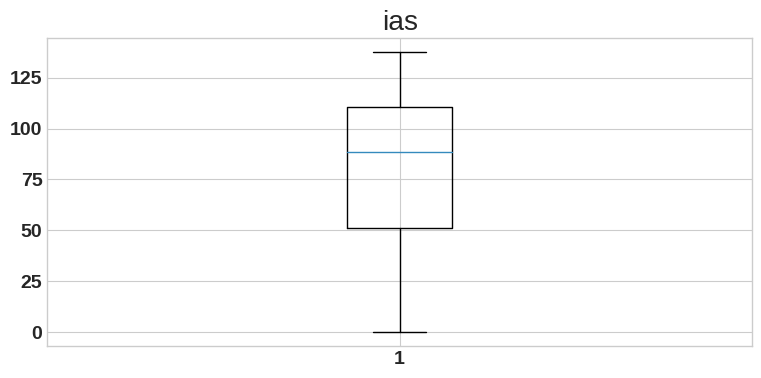

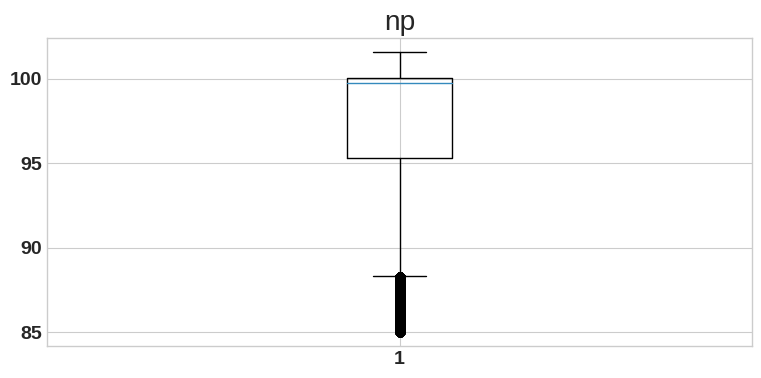

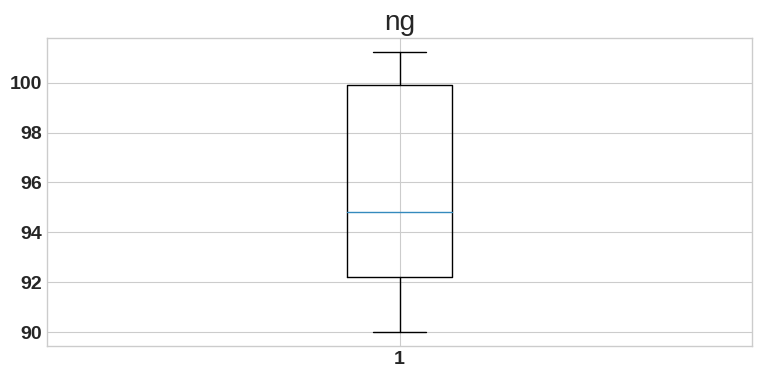

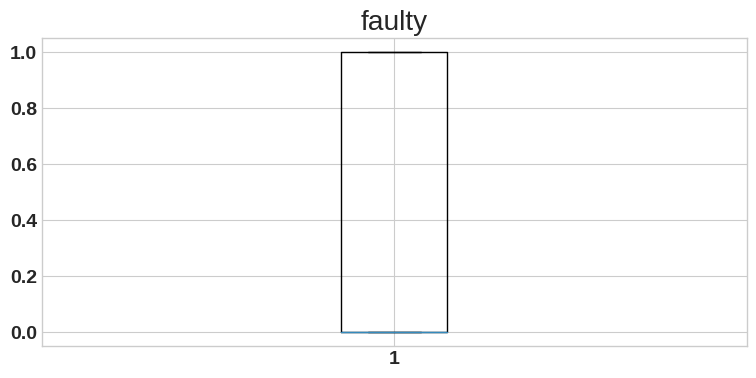

In [17]:
numerical = data_hs.select_dtypes(include=np.number).columns

for col in numerical:
  plt.figure(figsize=(20,4))
  plt.subplot(121)
  plt.boxplot(data_hs[col])
  plt.title(col)

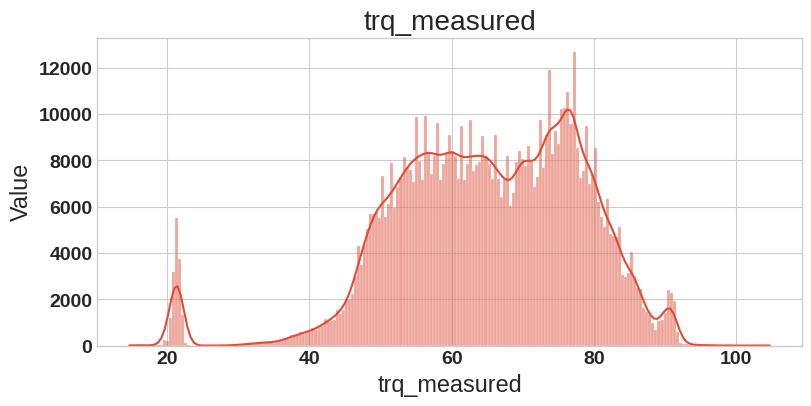

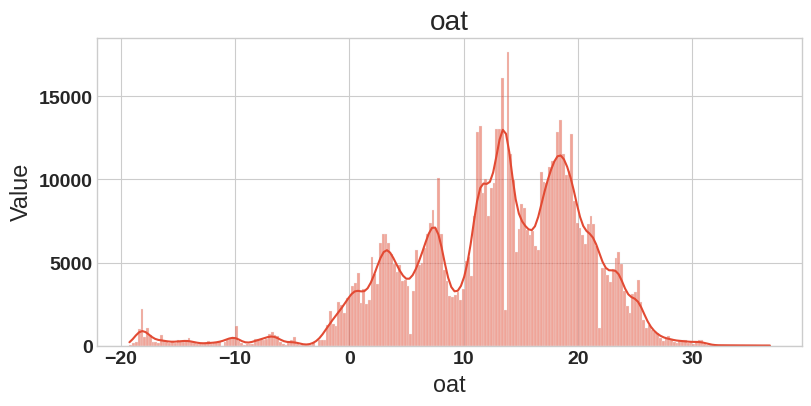

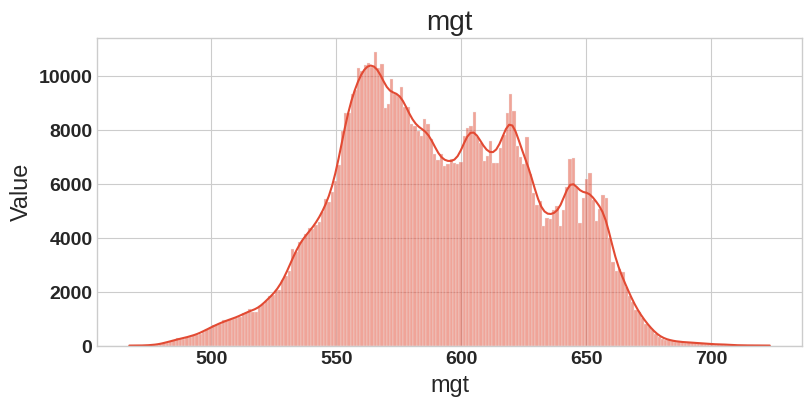

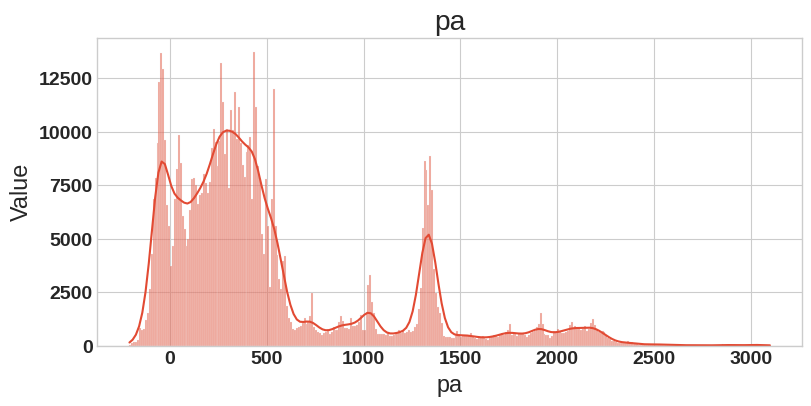

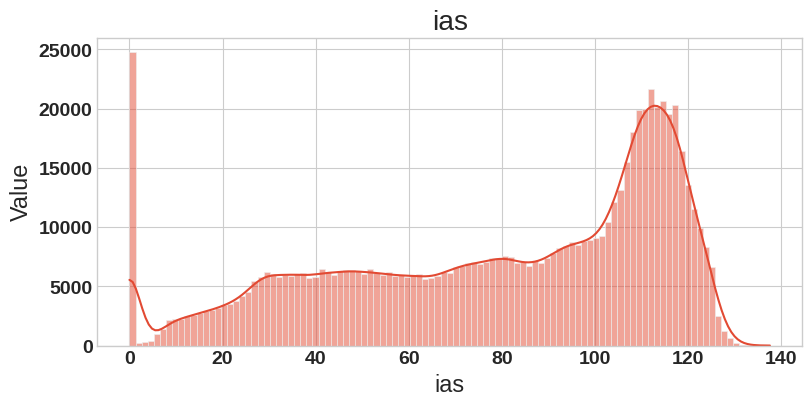

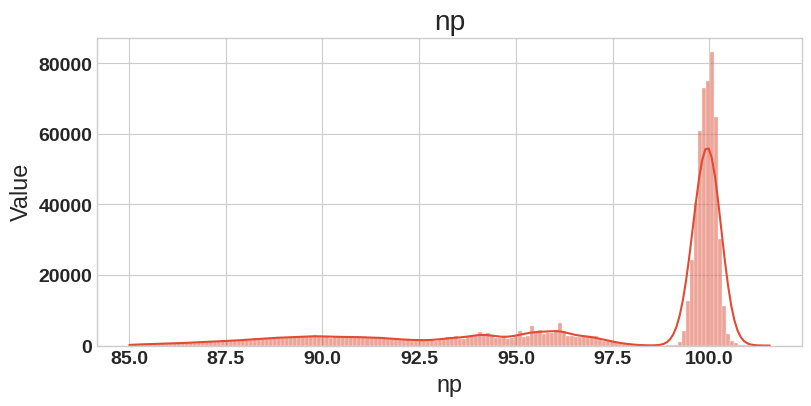

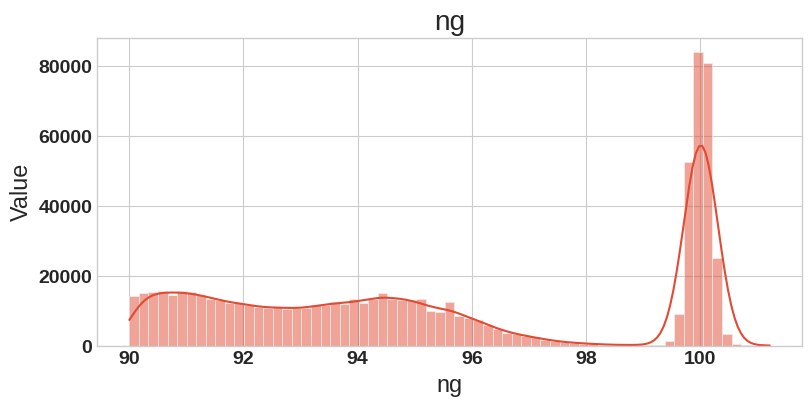

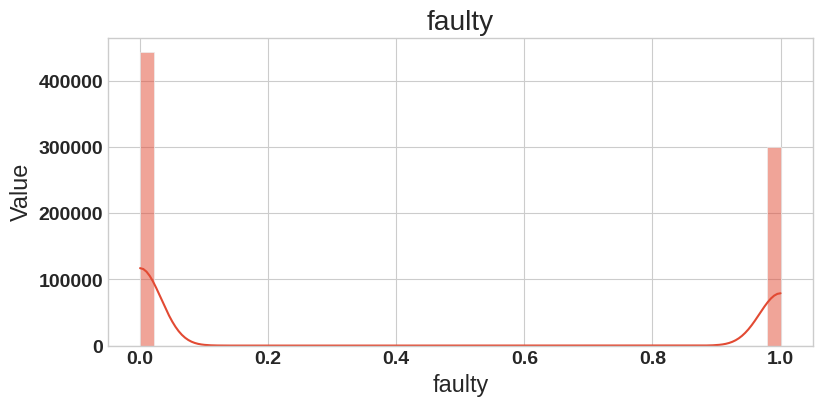

In [18]:
numerical = data_hs.select_dtypes(include=np.number).columns

for col in numerical:
  plt.figure(figsize=(20,4))
  plt.subplot(121)
  sns.histplot(data_hs[col],kde=True)
  plt.xlabel(col)
  plt.ylabel('Value')
  plt.title(col)

## Multivariate Analysis

<Axes: >

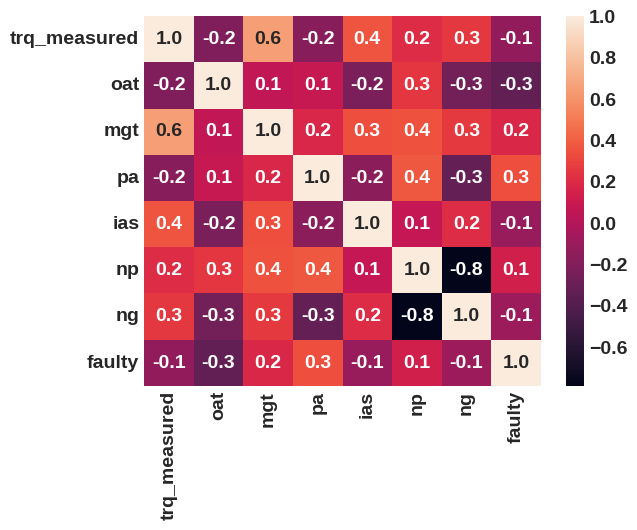

In [19]:
sns.heatmap(data_hs.corr(numeric_only=True), annot= True, fmt='.1f')

## Model Generation

### Manual

### Using Functions

In [20]:
from imblearn.combine import SMOTETomek

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_auc_score, RocCurveDisplay, precision_score, accuracy_score, recall_score

In [21]:
def model_run(data, name_y, modelo, param={}, metric="precision"):
    X = data.drop([name_y], axis=1)
    y = data[name_y]
    smote = SMOTETomek()
    X_sm, y_sm = smote.fit_resample(X,y)
    X_train, X_test, y_train, y_test = train_test_split(X_sm,y_sm,random_state=1)

    #train
    grid_model = GridSearchCV(modelo, param, scoring=metric)
    grid_model.fit(X_train, y_train)

    #
    y_pred = grid_model.best_estimator_.predict(X_test)

    #validation
    print(classification_report(y_test, y_pred))
    print(f'ROC AUC: {roc_auc_score(y_test, y_pred)}')
    print(f'Precision: {precision_score(y_test, y_pred)}')
    print(f'Recall: {recall_score(y_test, y_pred)}')
    print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
    RocCurveDisplay.from_predictions(y_test, y_pred)
    print(grid_model.get_params())

    return grid_model.best_estimator_

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


              precision    recall  f1-score   support

           0       0.91      0.92      0.92    111181
           1       0.92      0.91      0.92    110364

    accuracy                           0.92    221545
   macro avg       0.92      0.92      0.92    221545
weighted avg       0.92      0.92      0.92    221545

ROC AUC: 0.9155580130122074
Precision: 0.9167333503073509
Recall: 0.9134772208328803
Accuracy: 0.9155656864293936
{'cv': None, 'error_score': nan, 'estimator__C': 1.0, 'estimator__class_weight': None, 'estimator__dual': False, 'estimator__fit_intercept': True, 'estimator__intercept_scaling': 1, 'estimator__l1_ratio': None, 'estimator__max_iter': 100, 'estimator__multi_class': 'auto', 'estimator__n_jobs': None, 'estimator__penalty': 'l2', 'estimator__random_state': None, 'estimator__solver': 'lbfgs', 'estimator__tol': 0.0001, 'estimator__verbose': 0, 'estimator__warm_start': False, 'estimator': LogisticRegression(), 'n_jobs': None, 'param_grid': {}, 'pre_dispatch': 

LogisticRegression()

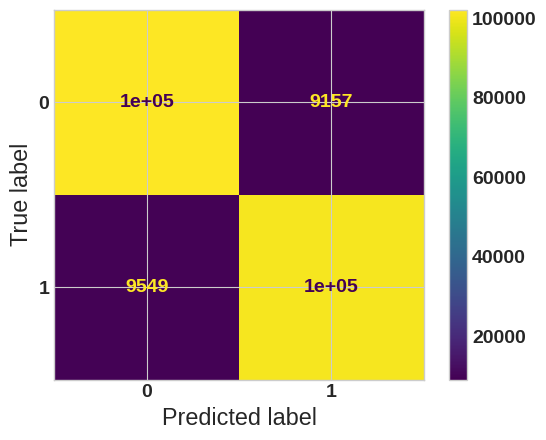

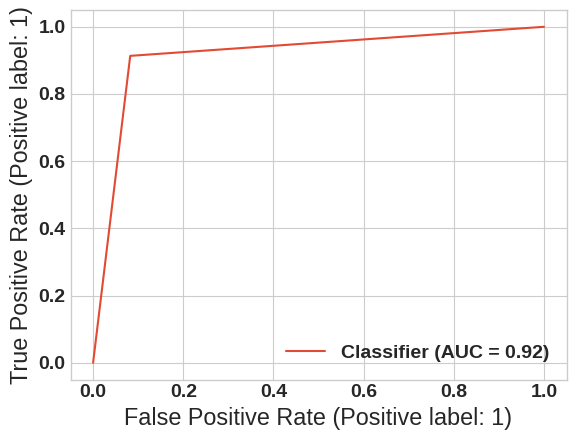

In [22]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression
rl = LogisticRegression()

param = {
    'penalty': ['l1','l2','elasticnet',None],
    "C": np.logspace(-2, 2, 50)
}

model_run(data_hs, 'faulty', rl)

In [23]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

rfc = RandomForestClassifier()
params_rfc = {
    'criterion': ['gini', 'log_loss', 'entropy'],
    'max_depth': [5, 10 ,15, 20, 25],
    'n_estimators': [100, 200]
}

In [24]:
model_run(data_hs, 'faulty', rfc, params_rfc)

KeyboardInterrupt: 

###Normalization for Adaboost

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
data_hs_minmax = data_hs.copy()
data_hs_minmax = pd.DataFrame(scaler.fit_transform(data_hs_minmax), columns=data_hs_minmax.columns)

In [ ]:
data_hs_minmax

In [ ]:
boost = AdaBoostClassifier()

params_boost = {
    'algorithm': ['SAMME', 'SAMME.R'],
    'n_estimators': [50, 100, 150]
}

model_run(data_hs_minmax, 'faulty', boost, params_boost, metric='precision')